In [27]:
#install below  packages
# !pip install easyocr
# !pip install opencv-python matplotlib
#!pip install mistralai
#!pip install gradio spaces transformers accelerate numpy requests torch torchvision qwen-vl-utils av ipython reportlab fpdf python-docx pillow huggingface_hub


# EASY OCR

In [ ]:
import easyocr
import cv2
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

easy_reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory


In [28]:
def display_image(path):
  img_bgr = cv2.imread(path)
  # Convert to RGB (matplotlib expects RGB)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  # Display image
  plt.imshow(img_rgb)
  plt.axis('off')
  plt.show()

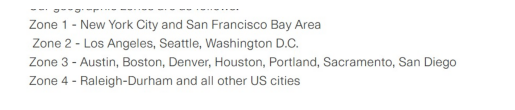

----------------Text--------------
Zone
New York City and San Francisco Bay Area
Zone 2
Los
Angeles; Seattle; Washington D.C.
Zone 3
Austin, Boston, Denver; Houston, Portland; Sacramento, San Diego
Zone 4
Raleigh-Durham and all other US cities


In [31]:
path = '/content/zones Info.jpg'
display_image(path)


result = easy_reader.readtext(path)
lines = len(result)
print('----------------Text--------------')
for l in range(0,lines):
  print(result[l][1])

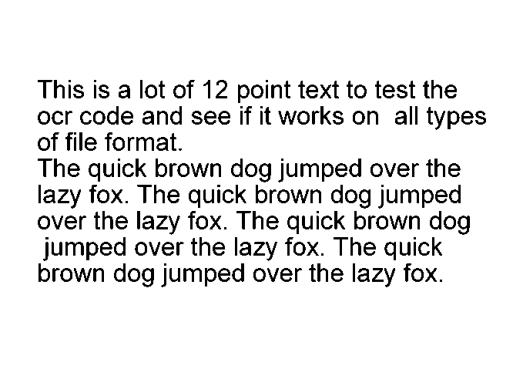

----------------Text--------------
This is a lot of 12 point text to test the
ocr code and see if it works on
all types
of file format:
The quick brown dog jumped over the
lazy fox The quick brown dog jumped
over the lazy fox. The quick brown dog
jumped over the lazy fox. The quick
brown dog jumped over the lazy fox.


In [33]:
path = '/content/OCR_text1.png'
display_image(path)


result = easy_reader.readtext(path)
lines = len(result)
print('----------------Text--------------')
for l in range(0,lines):
  print(result[l][1])

Long Text OCR

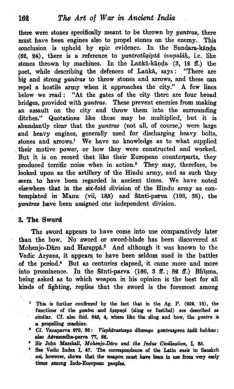

----------------Text--------------
162
The Art of Wat in Ancient India
there were stones
specifically meant to be thrown by yantras, there
must have been  engines also to propel stones
on thc
enemy.
This
conclusion
is   upheld
by
epic
evidencc
In
the   Sundara-kanda
(62, 24)
there
reference
yantrotksipta  ivopalih,
ie.  like
stones  throw by
machines_
In the Lanki-kunda
(8, 12 6)
the
poet,  while  describing  the  defences  of Laika,
says
"There
are
big and gtrong yantras to throw
stones and arTows, and these
can
repel
hostile
army   when
epproaches   the  city.
fcw
lincs
below
we
read
"At the
of the city therc
are
tour broad
bridges, povidcd with yanttas.
These prevent enemies from making
an
agsault
on
the
city
and   throw
them
the
surrounding
ditches
Quotations   like
thcse
may
be
multiplied,
but
abundantly
clear that the yuntras
(not all, of
course,)
were
large
and
heavy
engines,  generally
used   for   discharging   heavy
bolts,
stones   and
eITOWS _
We
have
n0
knowledge
85
to what

In [38]:
path = '/content/ocr_long_text2.jpg'
display_image(path)


result = easy_reader.readtext(path)
lines = len(result)
print('----------------Text--------------')
for l in range(0,lines):
  print(result[l][1])

# Transformer Based OCR - Qwen

In [69]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "prithivMLmods/Qwen2-VL-OCR-2B-Instruct", torch_dtype="auto", device_map="auto"
)
# default processer
processor = AutoProcessor.from_pretrained("prithivMLmods/Qwen2-VL-OCR-2B-Instruct")


messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "/content/OCR_text1.png",
            },
            {"type": "text", "text": "Extract text from this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cpu")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)



config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

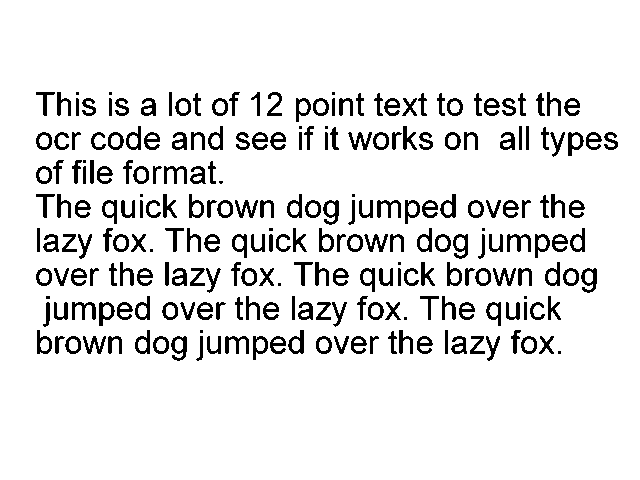

In [63]:
path = '/content/OCR_text1.png'
image = Image.open(path).convert("RGB")
image

In [75]:
for line in output_text[0].split('\n'):
    print(line)

This is a lot of 12 point text to test the
ocr code and see if it works on all types
of file format.
The quick brown dog jumped over the
lazy fox. The quick brown dog jumped
over the lazy fox. The quick brown dog
jumped over the lazy fox. The quick
brown dog jumped over the lazy fox.<|im_end|>


# LLM BASED - Mistral OCR

In [ ]:
import base64
import os
from mistralai import Mistral

def encode_image(image_path):
    """Encode the image to base64."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {image_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None

# Path to your image
image_path = "/content/OCR_text1.png"

# Getting the base64 string
base64_image = encode_image(image_path)

api_key = os.environ["MISTRAL_API_KEY"]  #ADD KEY
client = Mistral(api_key=api_key)

ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{base64_image}"
    },
    include_image_base64=True
)

# ** Multilingual OCR**


1.   EASY OCR
2.   MISTRAL
3.   OpenAI GPT-4o
4.   Claude Sonnet



